# AGDML-Lab Final
Task: Sentiment Analysis of Twitter messages

## Preprocessing
For preprocessing I used NLTK library. I removed non-alphabetic characters, made words lowercase, removed mentions of other users, removed stopwords and lemmatized each word to its lemma. This should make the data more consistent and easier to work with. My assumption is: most of the spelling mistakes and special characters are unnecessary for sentiment analysis.

The regex will most likely match stuff that we do not want removed, but that is a tradeoff we accept.

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch

tqdm.pandas()
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1060 6GB'

In [14]:
# read training data
df = pd.read_csv('data.csv')

# read validation data
df_test = pd.read_csv('data_valid.csv')

ct = len(df.loc[df['target'] == 1]) / len(df)
"positive messages", ct, "negative messages", 1-ct 

('positive messages', 0.499076, 'negative messages', 0.5009239999999999)

The dataset is evenly balanced. There is no bias towards negative or positive messages.

In [17]:
# preprocessing text messages
import re
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer

# download stopwords and wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

# create object of WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# this allows very
stopwords = set(stopwords.words('english'))
stopwords.remove('very')
print(stopwords)

correct_words = [str.lower(w) for w in words.words()]

from collections import Counter

WORDS = Counter(correct_words)

def P(word, N=sum(WORDS.values())):
    """Probability of `word`."""
    return WORDS[word] / N

def correction(word):
    """Most probable spelling correction for word."""
    return max(candidates(word), key=P)

def candidates(word):
    """Generate possible spelling corrections for word."""
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words):
    """The subset of `words` that appear in the dictionary of WORDS."""
    return set(w for w in words if w in WORDS)

def edits1(word):
    """All edits that are one edit away from `word`."""
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    """All edits that are two edits away from `word`."""
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

# function to clean text data
def clean_text(text):
    # remove mentions of other users
    text = re.sub('\B@[._a-zA-Z0-9]{3,24}', '', text)
    
    # rewrite words in all caps to "very" followed by word
    # text = re.sub('([A-Z]+)', lambda x: 'very ' + x.group(0).lower(), text)
    
    # make words lowercase, because Go and go will be considered as two words
    text = text.lower()
    # remove URLs from text
    text = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', ' ', text)
    # replace ampersand html tag with &
    text = re.sub('\&amp;', 'and', text)
    # remove everything but letters
    text = re.sub('[^a-z]', ' ', text)
    # split the sentences into words
    words = text.split() 
    for i in range(len(words)):
        # remove words with length 1
        if len(words[i]) == 1:
            words[i] = ''
        # remove repetition of letters
        _tmp = re.subn(r'([a-z])\1{3,}', r'\1', words[i])
        # prepend very if there were repeating letters
        # if _tmp[1] > 0:
        #     words[i] = "very " + _tmp[0]
    # remove stopwords like to, and, or etc.
    # words = [word for word in words if word not in stopwords]
    words = [correction(word) for word in words]
    # # lemmatize each word
    # words = [wordnet_lemmatizer.lemmatize(word) for word in words]
    # join words to make sentence
    text = ' '.join(words)
    # remove multiple spaces
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    
    return text

{"didn't", 'herself', 'when', 'don', 'each', 'hers', "you'd", "it's", 'his', "she's", "mustn't", 'you', 'he', 'before', 'only', 'should', 'on', 'here', 'doing', 'aren', 'were', "hadn't", "mightn't", 'ourselves', 'hadn', 'yourselves', 'with', "hasn't", 'its', 'her', 'too', 'while', 'themselves', 'am', 't', 'we', 'myself', 'it', 'through', 'mightn', 'shouldn', 'weren', "won't", 'himself', 'me', 'during', "that'll", 'off', 'yourself', 'same', "wouldn't", 'what', 'have', 'm', "aren't", 'ours', 'does', 'my', 'are', 'all', 'll', 'she', 'such', 'isn', 'for', 'they', 'other', 'those', 'did', 'by', 'will', 'until', 'own', 'most', 'ma', 'was', 'why', 'him', 'or', 'd', "wasn't", 'hasn', 'as', 'couldn', 'some', 'an', 'your', 'between', 'shan', "you'll", 'this', "weren't", 'no', 'so', 'o', 'into', 're', 'doesn', 'in', 'down', 'is', 'them', 'whom', 'again', "isn't", 'then', 'can', 'once', "you've", 'above', 'been', 'of', 'up', 'over', 'now', 'at', "shan't", "shouldn't", 'ain', 'do', "doesn't", 's', 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\frand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\frand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\frand\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# drop rows with missing values
df = df.dropna()
df_test = df_test.dropna()

# clean text data
# df['text'] = df['text'].progress_apply(clean_text)
# df.to_csv('data_cleaned.csv', index=False)    

df_test['text'] = df_test['text'].head(1000).progress_apply(clean_text)
df_test.to_csv('data_valid_cleaned.csv', index=False)

In [15]:
clean_text("can't find my phone charger.. So I'm switching my service over to my old phone")

'i find phone charger i i switching service old phone'

In [7]:
# read the csv file
# df = pd.read_csv('data_cleaned.csv')
# df_test = pd.read_csv('data_valid_cleaned.csv')

df_test

,text
0,very misset bowling fam very wish still
1,i start training hospital radio may th verse l...
2,i very confiscate bottle
3,very going
4,very very bo
...,...
99995,NaN
99996,NaN
99997,NaN
99998,NaN


In [18]:
# def drop_not_string(_df, column):
#     return _df.drop(_df[_df[column].apply(lambda x: isinstance(x, str)) == False].index)
# 
# drop_not_string(df, 'text')
# drop_not_string(df_test, 'text')

X = df['text']
y = df['target']

X_test = df_test['text']

# make them all strings
X = X.astype(str)
X_test = X_test.astype(str)

"sizes:", X.shape, y.shape, X_test.shape

('sizes:', (500000,), (500000,), (1000,))

## Word2Vec
Using the Gensim implementation of Google's Word2Vec.

In [19]:
from gensim.models import Word2Vec
sentences = [sentence.split() for sentence in X]
w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4, hs=1 , negative=0)

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_w2v = np.array([vectorize(sentence) for sentence in tqdm(X)])
X_test_w2v = np.array([vectorize(sentence) for sentence in tqdm(X_test)])

X_w2v.shape

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(500000, 100)

## Skip-Gram

In [20]:
from toolz import itertoolz, compose
from toolz.curried import map as cmap, sliding_window, pluck
from sklearn.feature_extraction.text import CountVectorizer

class SkipGramVectorizer(CountVectorizer):
    def build_analyzer(self):    
        preprocess = self.build_preprocessor()
        stop_words = self.get_stop_words()
        tokenize = self.build_tokenizer()
        return lambda doc: self._word_skip_grams(
                compose(tokenize, preprocess, self.decode)(doc),
                stop_words)

    def _word_skip_grams(self, tokens, stop_words=None):
        # handle stop words
        if stop_words is not None:
            tokens = [w for w in tokens if w not in stop_words]

        return compose(cmap(' '.join), pluck([0, 2]), sliding_window(3))(tokens)

## Mapping Visualisation
The 100-dimensional Word2Vec mapping of our features is reduced to a 2-dimensional space. The colouring is according to the label.

In [21]:
N = 10000

import umap
from sklearn.preprocessing import StandardScaler
reducer = umap.UMAP()
scaled_we = StandardScaler().fit_transform(X_w2v)
_embedding1 = reducer.fit_transform(scaled_we[:N])

C:\Users\frand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\frand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecatio

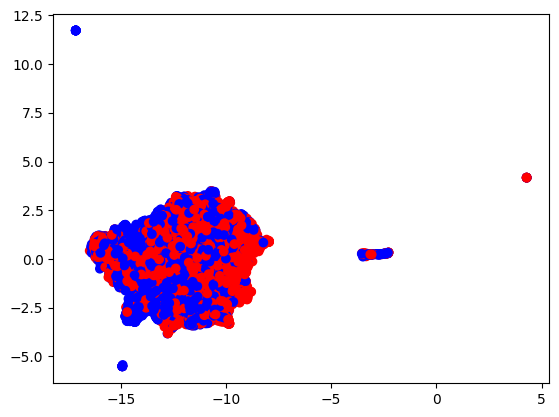

In [22]:
import matplotlib.pyplot as plt
plt.scatter(
    _embedding1[:, 0],
    _embedding1[:, 1],
    color=['r' if _y == 0 else 'b' for _y in y[:N]]
)

# Classifiers
This compares different classifiers. 

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB

embeddings = [{"name": "w2v", "data": X_w2v}, ]
classifiers = [LogisticRegression(), RidgeClassifier(), GaussianNB()]

for e in embeddings:
    _X_train, _X_test, _y_train, _y_test = train_test_split(e["data"], y, test_size=0.33)
    train_acc = []
    test_acc = []
    
    for c in tqdm(classifiers):
        c.fit(_X_train, _y_train)
        _y_hat_train = c.predict(_X_train)
        _y_hat_test = c.predict(_X_test)
        
        train_acc.append(accuracy_score(_y_hat_train, _y_train))
        test_acc.append(accuracy_score(_y_hat_test, _y_test))
        
pd.DataFrame({'embedding': list(map(lambda e: e["name"], embeddings))*len(classifiers), 'classifier': classifiers, 'train accuracy': train_acc, 'test accuracy': test_acc})

  0%|          | 0/3 [00:00<?, ?it/s]

,embedding,classifier,train accuracy,test accuracy
0,w2v,LogisticRegression(),0.735278,0.736006
1,w2v,RidgeClassifier(),0.733081,0.734321
2,w2v,GaussianNB(),0.638113,0.635503


## Transformer
Using a pre-trained transformer for sentiment analysis from Huggingface.
Score on the validation set: 0.71

This method is therefore worse than what I used before...